In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA
import time

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes


from plotnine import *
import plotnine


# supress warnings
import warnings
warnings.filterwarnings('ignore')


# Data viz lib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks

In [2]:
test_dataset = "dataset_test.npy"
train_dataset = "dataset_train.npy"
train_csv = 'csv_datasets/train_df.csv'
test_csv = 'csv_datasets/test_df.csv'

In [3]:
def load_data(np_dataset):
    data = pd.DataFrame(np.load(np_dataset,allow_pickle= True))
    data.columns = ['mfccs', 'chroma', 'mel', 'contrast', 'tonnetz', 'labels']
    return data
    
data_train = load_data(train_dataset)

In [4]:
data_train

,mfccs,chroma,mel,contrast,tonnetz,labels
0,"[-120.44989, 141.28731, -97.689674, 51.246986,...","[0.5127197, 0.6289829, 0.67859983, 0.6120176, ...","[0.00034424057, 0.0024971303, 0.03392932, 0.04...","[27.14615868072248, 16.24670729449546, 16.3969...","[0.008315249975639353, -0.04078186593573324, 0...",Electric_guitar
1,"[-462.5201, 125.56154, 90.61009, 42.466038, 8....","[0.14299631, 0.18703218, 0.11590953, 0.2136829...","[0.05023931, 0.080697715, 0.64686084, 16.97148...","[26.59156421483945, 27.742263850692684, 27.162...","[0.04832218206584504, 0.0007057545689226547, -...",Electric_guitar
2,"[-482.1192, 109.78271, 93.44149, 48.886395, 8....","[1.0, 0.56950074, 0.15186827, 0.056334578, 0.0...","[0.05195219, 0.04212178, 0.053895682, 1.546472...","[26.402870864258244, 26.81197464815876, 30.807...","[0.0042054153099592, 0.047017267393978886, 0.0...",Electric_guitar
3,"[-505.82874, 64.36437, 61.27707, 32.283733, 19...","[1.0, 0.4515016, 0.08700509, 0.046527263, 0.04...","[0.11376906, 0.15674245, 0.18782516, 0.2022806...","[12.879226135767187, 32.49173142349057, 21.727...","[-0.0047681396878248485, 0.04853678907471287, ...",Electric_guitar
4,"[-310.77927, 170.7843, 43.114513, 36.16818, -5...","[0.49481386, 0.45342273, 0.5104569, 0.50238496...","[0.14299296, 0.33679408, 1.7173584, 14.120503,...","[22.472560631705775, 20.070113058398245, 24.40...","[0.020563136833671513, 0.0039837619331182135, ...",Electric_guitar
...,...,...,...,...,...,...
39561,"[-296.5924, 101.06481, -17.77941, 15.349553, -...","[0.75361663, 0.718668, 0.6826718, 0.64143205, ...","[0.11669232, 0.1612427, 0.17919922, 0.12772878...","[14.142535711245364, 11.648771633734441, 14.26...","[0.005308342674339312, 0.01862250652009528, -0...",Goose
39562,"[-504.05615, 103.33491, 19.444485, -4.572045, ...","[0.6182252, 0.55635905, 0.5410558, 0.5871857, ...","[0.34660092, 0.10748821, 0.022130141, 0.023008...","[19.92006489471457, 12.02116855523543, 17.3503...","[-0.02143542812515614, 0.033508587402217335, -...",Goose
39563,"[-310.33325, 89.40691, -34.036705, 15.999105, ...","[0.7662366, 0.743348, 0.7271631, 0.73783237, 0...","[2.336847, 1.3064721, 0.25293216, 0.07206618, ...","[12.49760533036952, 11.560274145559992, 12.817...","[-0.006198496724948723, 0.019674623209252572, ...",Duck
39564,"[-287.25082, 83.980965, -14.652512, 3.05485, -...","[0.59229547, 0.5853054, 0.5667196, 0.5610734, ...","[0.107432, 0.34983456, 0.36349782, 0.11873577,...","[16.465401911314192, 12.649185017321859, 16.67...","[-0.004094468936082029, 0.01074505236157949, 0...",Duck


In [5]:
# first convert seq column to a 2d array
mfccs_col = np.vstack(data_train['mfccs'].values).astype(float)
chroma_col = np.vstack(data_train['chroma'].values).astype(float)
mel_col = np.vstack(data_train['mel'].values).astype(float)
contrast_col = np.vstack(data_train['contrast'].values).astype(float)
tonnetz_col = np.vstack(data_train['tonnetz'].values).astype(float)

In [6]:
sc_col2 = StandardScaler()
mfccs_col2 = sc_col2.fit_transform(mfccs_col)
chroma_col2 = sc_col2.fit_transform(chroma_col)
mel_col2 = sc_col2.fit_transform(mel_col)
contrast_col2 = sc_col2.fit_transform(contrast_col)
tonnetz_col2 = sc_col2.fit_transform(tonnetz_col)


x = np.hstack((mfccs_col, chroma_col, mel_col, contrast_col, tonnetz_col))
y = data_train.loc[:,['labels']].values# Standardizing the features

In [7]:
time_start = time.time()

pca = PCA(n_components=5)
pca_result = pca.fit_transform(x)

print ('PCA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PCA done! Time elapsed: 2.2429120540618896 seconds


In [8]:
pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4', 'pca5'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]
pca_df['pca5'] = pca_result[:,4]
pca_df['labels'] = data_train['labels']

print ('Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))
X = pca_df[["pca1","pca2"]]
pca_df.to_csv('csv_datasets/pcaandkmeans.csv')

Variance explained per principal component: [0.19026418 0.13736347 0.08134011 0.06225513 0.04405296]


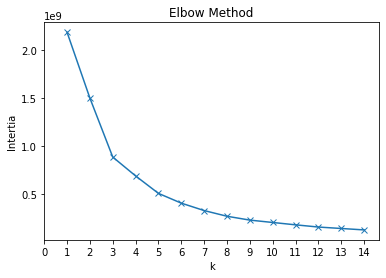

In [9]:
#Find Best K
intertia = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    intertia.append(km.inertia_)
plt.plot(K, intertia, marker= "x")
plt.xlabel('k')
plt.xticks(np.arange(15))
plt.ylabel('Intertia')
plt.title('Elbow Method')
plt.show()

In [10]:
km = KMeans(n_clusters=7, n_init = 3, init = "random", random_state = 42)
km.fit(X)
y_kmeans = km.predict(X)
y_kmeans

array([1, 6, 6, ..., 2, 2, 1], dtype=int32)

In [11]:
pca_df['cluster'] = y_kmeans
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,labels,cluster
0,153.348079,-223.304223,-49.450693,39.909006,-29.383230,Electric_guitar,1
1,-64.708765,49.230289,14.191215,-19.679428,2.787890,Electric_guitar,6
2,-79.795916,63.014726,11.987884,-21.869163,23.511241,Electric_guitar,6
3,-97.718506,78.114814,16.420888,-24.432272,62.494290,Electric_guitar,6
4,45.208880,-72.584107,8.736511,-15.305926,11.545764,Electric_guitar,2


In [12]:
# Add the cluster to the dataframe
data_train['Cluster Labels'] = km.labels_
data_train['Segment'] = data_train['Cluster Labels'].map({0:'One', 1:'Two', 2:'Three', 3:'Four', 4:'Five', 5:'Six', 6:'Seven'})
# Order the cluster
data_train['Segment'] = data_train['Segment'].astype('category')
data_train['Segment'] = data_train['Segment'].cat.reorder_categories(['One','Two','Three','Four','Five','Six', 'Seven'])

In [13]:
data_train

,mfccs,chroma,mel,contrast,tonnetz,labels,Cluster Labels,Segment
0,"[-120.44989, 141.28731, -97.689674, 51.246986,...","[0.5127197, 0.6289829, 0.67859983, 0.6120176, ...","[0.00034424057, 0.0024971303, 0.03392932, 0.04...","[27.14615868072248, 16.24670729449546, 16.3969...","[0.008315249975639353, -0.04078186593573324, 0...",Electric_guitar,1,Two
1,"[-462.5201, 125.56154, 90.61009, 42.466038, 8....","[0.14299631, 0.18703218, 0.11590953, 0.2136829...","[0.05023931, 0.080697715, 0.64686084, 16.97148...","[26.59156421483945, 27.742263850692684, 27.162...","[0.04832218206584504, 0.0007057545689226547, -...",Electric_guitar,6,Seven
2,"[-482.1192, 109.78271, 93.44149, 48.886395, 8....","[1.0, 0.56950074, 0.15186827, 0.056334578, 0.0...","[0.05195219, 0.04212178, 0.053895682, 1.546472...","[26.402870864258244, 26.81197464815876, 30.807...","[0.0042054153099592, 0.047017267393978886, 0.0...",Electric_guitar,6,Seven
3,"[-505.82874, 64.36437, 61.27707, 32.283733, 19...","[1.0, 0.4515016, 0.08700509, 0.046527263, 0.04...","[0.11376906, 0.15674245, 0.18782516, 0.2022806...","[12.879226135767187, 32.49173142349057, 21.727...","[-0.0047681396878248485, 0.04853678907471287, ...",Electric_guitar,6,Seven
4,"[-310.77927, 170.7843, 43.114513, 36.16818, -5...","[0.49481386, 0.45342273, 0.5104569, 0.50238496...","[0.14299296, 0.33679408, 1.7173584, 14.120503,...","[22.472560631705775, 20.070113058398245, 24.40...","[0.020563136833671513, 0.0039837619331182135, ...",Electric_guitar,2,Three
...,...,...,...,...,...,...,...,...
39561,"[-296.5924, 101.06481, -17.77941, 15.349553, -...","[0.75361663, 0.718668, 0.6826718, 0.64143205, ...","[0.11669232, 0.1612427, 0.17919922, 0.12772878...","[14.142535711245364, 11.648771633734441, 14.26...","[0.005308342674339312, 0.01862250652009528, -0...",Goose,2,Three
39562,"[-504.05615, 103.33491, 19.444485, -4.572045, ...","[0.6182252, 0.55635905, 0.5410558, 0.5871857, ...","[0.34660092, 0.10748821, 0.022130141, 0.023008...","[19.92006489471457, 12.02116855523543, 17.3503...","[-0.02143542812515614, 0.033508587402217335, -...",Goose,6,Seven
39563,"[-310.33325, 89.40691, -34.036705, 15.999105, ...","[0.7662366, 0.743348, 0.7271631, 0.73783237, 0...","[2.336847, 1.3064721, 0.25293216, 0.07206618, ...","[12.49760533036952, 11.560274145559992, 12.817...","[-0.006198496724948723, 0.019674623209252572, ...",Duck,2,Three
39564,"[-287.25082, 83.980965, -14.652512, 3.05485, -...","[0.59229547, 0.5853054, 0.5667196, 0.5610734, ...","[0.107432, 0.34983456, 0.36349782, 0.11873577,...","[16.465401911314192, 12.649185017321859, 16.67...","[-0.004094468936082029, 0.01074505236157949, 0...",Duck,2,Three


In [14]:
data_train.to_csv('csv_datasets/PCAandKMeans.csv')

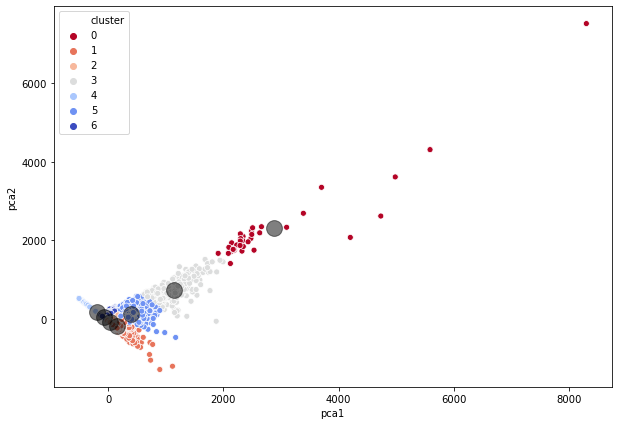

In [15]:
# Plot clusters - this is done by colour coding the data points according to which cluster the data point belongs to
fig = plt.figure(figsize=(10, 7))
fig = sns.scatterplot(data=pca_df, x='pca1', y='pca2', hue= 'cluster', palette = "coolwarm_r", legend="full")
centers = km.cluster_centers_# Plot centers
fig = plt.scatter(centers[:, 0], centers[:, 1], c='black', s=250, alpha = 0.5);

In [16]:
def clusters():
    #print("################ Cluster" + ' ' + segment + ' ################')
    #cluster = data_train.loc[data_train['Segment'] == segment]
    #labels_cluster = cluster['labels'].unique()
    #labels_count = cluster['labels'].count()
    
    count_series = data_train.groupby(['labels', 'Segment']).size()
    
    return count_series
   
    
    #return labels_cluster, labels_count
count_series = clusters() 
new_df = pd.DataFrame(count_series)
new_df.head()
new_df.to_csv('csv_datasets/new.csv')